In [1]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [2]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

Observe the lifetime of servers

In [5]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
sample_time1 = ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']
sample_time2 = ['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '23:59:59']

In [6]:
st = f'2019-10-28T00:00:00Z' 
et = f'2019-11-10T23:59:59Z'
q = build_query(st, et, loc='west-us', lang=None)
result = client.query(q)
server_set, _ = get_edge_num(result)
server_list = list(server_set)
print(len(server_set))
print(len(server_list))

197
197


In [20]:
server_lifetime_table = np.zeros((len(server_list), len(date)*len(sample_time1)), dtype=int)
print(server_lifetime_table.shape)
for i, dat in enumerate(date):
    for j, (t1, t2) in enumerate(zip(sample_time1, sample_time2)):
        st = f'2019-{dat}T{t1}Z'
        et = f'2019-{dat}T{t2}Z'
        q = build_query(st, et, loc='west-us', lang=None)
        result = client.query(q)
        server_set, _ = get_edge_num(result)
        print(dat, t1, t2, server_set)
        for k, server in enumerate(server_list):
            if server in server_set:
                server_lifetime_table[k, i*24+j] = 1
print(server_lifetime_table)

(197, 336)
10-28 00:00:00 01:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.76', '52.223.228.9', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.248', '99.181.96.118', '52.223.247.73', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '52.223.228.37', '99.181.96.162', '52.223.247.38', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.247.233'

10-28 08:00:00 09:00:00 {'52.223.225.214', '99.181.96.109', '99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '99.181.96.120', '52.223.228.85', '99.181.96.111', '99.181.96.112', '52.223.228.40', '52.223.228.18', '99.181.96.165', '99.181.96.106', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.29', '99.181.96.108', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.52', '52.223.228.122', '99.181.96.133', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '99.181.96.163', '52.223.228.89', '52.223.228.106', '52.223.228.37', '52.223.228.5', '99.181.96.162', '52.223.228.27', '52.223.228.59', '52.223.228.68', '99.181.96.115', '52.223.227.241', '52.223.227.232', '52.223.227.240', '99.181.96.189', '99.181.96.134', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.230', '99.181.96.11

10-28 15:00:00 16:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.125', '52.223.228.52', '52.223.228.29', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.94', '52.223.228.97', '52.223.228.99', '52.223.227.248', '52.223.227.230', '52.223.226.26', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-28 16:00:00 17:00:00 {'52.223.227.243', '52.223.247.33', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52

10-28 23:00:00 23:59:59 {'99.181.96.109', '52.223.227.243', '52.223.228.13', '52.223.247.152', '52.223.227.234', '52.223.247.170', '52.223.228.118', '52.223.228.96', '52.223.228.85', '99.181.96.111', '52.223.228.40', '99.181.96.165', '52.223.228.18', '99.181.96.106', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.29', '52.223.228.52', '52.223.228.125', '52.223.228.98', '99.181.96.133', '52.223.228.103', '52.223.228.122', '52.223.247.237', '52.223.247.160', '52.223.228.25', '52.223.228.4', '52.223.247.86', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.247.211', '52.223.228.37', '52.223.247.63', '99.181.96.162', '52.223.228.27', '52.223.228.59', '52.223.247.171', '52.223.228.68', '99.181.96.115', '52.223.247.72', '52.223.227.241', '52.223.227.232', '52.223.247.185', '52.223.227.240', '99.181.96.189', '52.223.228.93', '99.181.96.134', '52.223.247.43', '52.223.228.28', '52.223.247.119', '52.223.228.97', '52.22

10-29 06:00:00 07:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.29', '52.223.228.52', '52.223.228.9', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-29 07:00:00 08:00:00 {'52.223.227.243', '52.223.247.33', '52.223.228.96', '52.223.247.95', '52.223.247.76', '52

10-29 13:00:00 14:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '52.223.247.166', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.225.159', '52.2

10-29 18:00:00 19:00:00 {'52.223.247.167', '52.223.247.233', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.247.89', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.95', '52.223.228.92', '52.223.247.120', '52.223.228.7', '52.223.228.9', '52.223.228.29', '52.223.228.125', '52.223.228.52', '52.223.228.103', '52.223.247.91', '52.223.228.98', '52.223.228.49', '52.223.228.122', '52.223.247.42', '52.223.247.150', '52.223.247.237', '52.223.228.25', '52.223.247.160', '52.223.228.4', '52.223.247.86', '52.223.228.107', '52.223.247.46', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.247.211', '52.223.228.106', '52.223.228.89', '52.223.247.63', '52.223.228.37', '52.223.248.235', '52.223.228.27', '52.223.228.59', '52.223.247.171', '52.223.228.68', '52.223.247.72', '52.223.247.93', '52.223.227.241', '52.223.227.232', '52.223.247.111', '52.223.227.240', '52.223.228.93', '52.223.247.236', '52.223.228.28', '52

10-30 03:00:00 04:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.29', '52.223.228.125', '52.223.228.52', '52.223.228.98', '52.223.228.103', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.30', '52.223.228.94', '52.223.228.99', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-30 04:00:00 05:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

10-30 10:00:00 11:00:00 {'52.223.227.243', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.76', '52.223.228.9', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '52.223.228.37', '99.181.96.162', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.22

10-30 15:00:00 16:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.29', '52.223.228.52', '52.223.228.125', '52.223.228.9', '52.223.228.98', '52.223.228.103', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-30 16:00:00 17:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '9

10-30 22:00:00 23:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.125', '52.223.228.52', '52.223.228.29', '52.223.228.103', '52.223.228.98', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-30 23:00:00 23:59:59 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

10-31 08:00:00 09:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.125', '52.223.228.29', '52.223.228.9', '52.223.228.98', '52.223.228.103', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.94', '52.223.228.97', '52.223.228.99', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
10-31 09:00:00 10:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

10-31 14:00:00 15:00:00 {'52.223.227.243', '52.223.228.96', '99.181.96.112', '52.223.247.95', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.228.30', '52.223.228.94', '52.223.228.97', '52.223.228.99', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.228.40', '52.223.228.18', '99.181.96.165', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '99.181.96.162', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.247.233', '52.223.247.152', '52.223.2

10-31 22:00:00 23:00:00 {'99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '99.181.96.111', '52.223.228.40', '52.223.228.18', '99.181.96.112', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.125', '52.223.228.29', '52.223.228.52', '52.223.228.103', '52.223.228.98', '99.181.96.108', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.5', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '99.181.96.134', '52.223.228.93', '99.181.96.189', '52.223.228.28', '52.223.228.30', '52.223.228.94', '52.223.228.99', '52.223.228.97', '52.223.227.248', '52.223.227.230', '99.181.96.118', '52.223.228.10', '99.181.96.135', '52.223.228.17', '99.181.96.125', '52.223.227.219', '99.181.96.122', '52.223.228.102', '52.223.228

11-01 06:00:00 07:00:00 {'99.181.96.109', '99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '99.181.96.120', '52.223.228.85', '99.181.96.111', '52.223.247.89', '99.181.96.112', '52.223.228.18', '99.181.96.165', '52.223.228.40', '99.181.96.106', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.125', '52.223.228.9', '52.223.228.29', '52.223.228.98', '52.223.228.103', '99.181.96.133', '52.223.228.122', '52.223.228.49', '99.181.96.108', '99.181.96.167', '52.223.247.237', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '99.181.96.163', '52.223.228.37', '52.223.228.5', '99.181.96.162', '52.223.228.27', '52.223.228.59', '52.223.228.68', '99.181.96.115', '52.223.247.93', '52.223.227.241', '52.223.227.232', '99.181.96.189', '99.181.96.134', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.97', '52.223.228.99

11-01 13:00:00 14:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.22

11-01 20:00:00 21:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.52', '52.223.228.29', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-01 21:00:00 22:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '5

11-02 04:00:00 05:00:00 {'99.181.96.109', '99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '99.181.96.120', '52.223.228.85', '99.181.96.111', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '99.181.96.112', '99.181.96.106', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.29', '52.223.228.52', '52.223.228.125', '52.223.228.103', '52.223.228.98', '99.181.96.108', '52.223.228.49', '52.223.228.122', '52.223.247.237', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.247.46', '52.223.228.123', '99.181.96.156', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '99.181.96.163', '52.223.228.37', '52.223.247.63', '99.181.96.162', '52.223.228.27', '52.223.228.59', '52.223.228.5', '52.223.228.68', '99.181.96.115', '52.223.247.38', '52.223.247.72', '52.223.227.241', '52.223.227.232', '52.223.227.240', '99.181.96.134', '52.223.228.93', '99.181.96.189', '52.223.228.28

11-02 10:00:00 11:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.94', '52.223.228.99', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '99.181.96.165', '52.223.228.18', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223

11-02 15:00:00 16:00:00 {'52.223.227.243', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.160', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.247.99', '52.223.227.232', '52.223.247.119', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.228.37', '99.181.96.162', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.227.234', '52.223.228.118', '52.223.

11-02 21:00:00 22:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.228.9', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.2

11-03 02:00:00 03:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223

11-03 07:00:00 08:00:00 {'52.223.227.243', '52.223.247.33', '52.223.228.96', '52.223.247.89', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.18

11-03 12:00:00 13:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.18

11-03 17:00:00 18:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '52.223.247.96', '52.223.228.102', '52.223.228.24', '52.223.247.170', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.247.233', '52.223.247.152', '52.223.227.234', '52.223.228.118', '52.223.228.85', '52.223.228.92', '52.223.228.52', '52.223.228.29', '52.223.247.105', '52.223.228.106', '52.223.247.39', '52.223.247.146', 

11-03 23:00:00 23:59:59 {'52.223.227.243', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.247.99', '52.223.227.232', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.248', '99.181.96.118', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '99.181.96.120', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.228.37', '99.181.96.162', '52.223.247.38', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.227.234', '52.223.228.118', '52.223.228.85', '99.181.96.111', '52.223.228.92', '52.223.228.52', '52.223.22

11-04 06:00:00 07:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '52.223.228.10', '52.

11-04 11:00:00 12:00:00 {'52.223.227.243', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.227.232', '52.223.247.119', '52.223.228.97', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.227.248', '99.181.96.118', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.

11-04 17:00:00 18:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '52.223.247.95', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.94', '52.223.228.97', '52.223.228.99', '52.223.227.248', '52.223.247.96', '52.223.247.166', '52.223.247.73', '52.223.228.102', '52.223.228.24', '52.223.247.170', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '52.223.247.38', '52.223.247.111', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.247.152', '52.223.227.234', '52.223.228.118', '52.223.228.85', '52.223.228.92', '52.223.228.52', '52.223.228.29', '

11-05 00:00:00 01:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.29', '52.223.228.125', '52.223.228.9', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-05 01:00:00 02:00:00 {'99.181.96.109', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '5

11-05 08:00:00 09:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.52', '52.223.228.125', '52.223.228.29', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.94', '52.223.228.30', '52.223.228.99', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-05 09:00:00 10:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

11-05 14:00:00 15:00:00 {'99.181.96.107', '99.181.96.109', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '99.181.96.120', '52.223.228.85', '99.181.96.111', '99.181.96.112', '52.223.228.18', '52.223.228.40', '99.181.96.165', '99.181.96.106', '52.223.228.92', '52.223.228.7', '52.223.228.9', '52.223.228.52', '99.181.96.108', '52.223.228.125', '52.223.228.98', '99.181.96.133', '52.223.228.29', '52.223.228.122', '52.223.228.49', '52.223.228.103', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '99.181.96.156', '52.223.228.95', '52.223.228.26', '99.181.96.163', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.5', '99.181.96.162', '52.223.228.27', '52.223.228.59', '52.223.228.68', '99.181.96.115', '52.223.227.241', '52.223.227.232', '52.223.227.240', '99.181.96.134', '99.181.96.189', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.230

11-05 21:00:00 22:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.29', '52.223.228.9', '52.223.228.52', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-05 22:00:00 23:00:00 {'99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '5

11-06 06:00:00 07:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.125', '52.223.228.9', '52.223.228.29', '52.223.228.103', '52.223.228.98', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-06 07:00:00 08:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

11-06 13:00:00 14:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.76', '52.223.228.9', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.227.232', '52.223.247.119', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.248', '99.181.96.118', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '99.181.96.120', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.247.152', '52.223.227.234', '52.223.228.118', '52.223.

11-06 18:00:00 19:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '52.223.247.96', '52.223.247.73', '52.223.247.166', '52.223.228.102', '52.223.228.24', '52.223.247.170', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.247.211', '52.223.228.37', '52.223.247.38', '52.223.247.111', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.247.233', '52.223.247.152', '52.223.227.234', '52.223.228.118', '52.223.228.85', '52.223.228.92', 

11-07 04:00:00 05:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.125', '52.223.228.9', '52.223.228.29', '52.223.228.98', '52.223.228.103', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-07 05:00:00 06:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '

11-07 12:00:00 13:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.99', '52.223.228.94', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '99.181.96.165', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.18

11-07 17:00:00 18:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.248.213', '52.223.247.91', '52.223.247.160', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.164', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.18

11-08 01:00:00 02:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.7', '52.223.228.52', '52.223.228.125', '52.223.228.9', '52.223.228.29', '52.223.228.103', '52.223.228.98', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-08 02:00:00 03:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '

11-08 09:00:00 10:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.9', '52.223.228.29', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.49', '52.223.228.122', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-08 10:00:00 11:00:00 {'99.181.96.109', '99.181.96.107', '52.223.227.243', '52.223.228.13', '52.223.227.234', '5

11-08 14:00:00 15:00:00 {'52.223.227.243', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.30', '52.223.228.94', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.22

11-09 03:00:00 04:00:00 {'52.223.247.233', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.29', '52.223.228.125', '52.223.228.52', '52.223.228.9', '52.223.228.98', '52.223.228.103', '52.223.247.42', '52.223.228.122', '52.223.228.49', '52.223.247.91', '52.223.228.25', '52.223.228.4', '52.223.247.86', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.247.38', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.247.236', '52.223.247.43', '52.223.228.28', '52.223.247.119', '52.223.228.30', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.247.73', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.

11-09 08:00:00 09:00:00 {'52.223.247.233', '52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.52', '52.223.228.9', '52.223.228.125', '52.223.228.29', '52.223.228.98', '52.223.228.103', '52.223.247.42', '52.223.228.49', '52.223.228.122', '52.223.247.91', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.247.99', '52.223.227.241', '52.223.227.232', '52.223.247.111', '52.223.227.240', '52.223.228.93', '52.223.247.236', '52.223.247.43', '52.223.228.28', '52.223.247.119', '52.223.228.30', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.

11-09 14:00:00 15:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.150', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.94', '52.223.228.99', '52.223.228.30', '52.223.227.248', '52.223.247.96', '52.223.247.166', '52.223.247.73', '52.223.228.102', '52.223.228.24', '52.223.247.170', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '52.223.228.37', '52.223.247.38', '52.223.247.111', '52.223.227.230', '52.223.228.10', '52.223.228.17', '52.223.247.233', '52.223.247.152', '52.223.227.234', '52.223.228.118', '52.223.228.85', '52.223.228.92', '52.223.228.52', '52.223.228.29', '52.223.247.105', '

11-09 19:00:00 20:00:00 {'52.223.227.243', '52.223.228.13', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.228.7', '52.223.228.29', '52.223.228.125', '52.223.228.52', '52.223.228.9', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.228.37', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.227.241', '52.223.227.232', '52.223.227.240', '52.223.228.93', '52.223.228.28', '52.223.228.30', '52.223.228.94', '52.223.228.99', '52.223.228.97', '52.223.227.230', '52.223.227.248', '52.223.228.10', '52.223.228.17', '52.223.227.219', '52.223.228.102', '52.223.228.24', '52.223.228.8', '52.223.228.5', '52.223.228.87', '52.223.228.90'}
11-09 20:00:00 21:00:00 {'99.181.96.107', '99.181.96.109', '52.223.227.243', '52.223.228.13', '52.223.227.234', '5

11-10 02:00:00 03:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '52.223.247.89', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.72', '52.223.247.99', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.30', '52.223.228.94', '52.223.228.99', '52.223.228.97', '52.223.227.248', '99.181.96.118', '52.223.247.96', '52.223.247.166', '52.223.247.73', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.18

11-10 08:00:00 09:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '99.181.96.112', '52.223.247.76', '52.223.228.9', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.247.63', '52.223.228.68', '52.223.247.99', '52.223.227.232', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.73', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '52.223.247.170', '99.181.96.120', '52.223.247.87', '52.223.228.40', '52.223.228.18', '52.223.247.229', '52.223.228.125', '52.223.228.103', '52.223.228.98', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '52.223.247.38', '52.223.247.111', '52.223.227.230', '52.223.228.10', '52.223.228.17', '99.181.96.122', '99.181.96.110', '99.181.96.109', '52.223.247.233', '52.223.227.234', '52.223.228.118', '52.

11-10 13:00:00 14:00:00 {'52.223.227.243', '52.223.247.33', '52.223.247.135', '52.223.228.96', '99.181.96.112', '52.223.247.95', '52.223.247.76', '52.223.228.9', '52.223.247.237', '52.223.247.91', '52.223.247.160', '52.223.247.150', '99.181.96.167', '52.223.228.25', '52.223.228.4', '52.223.228.107', '99.181.96.163', '52.223.228.89', '52.223.228.68', '52.223.227.232', '52.223.247.236', '52.223.247.119', '52.223.228.97', '52.223.228.99', '52.223.228.94', '52.223.228.30', '52.223.227.248', '99.181.96.118', '52.223.247.166', '99.181.96.125', '52.223.228.102', '52.223.228.24', '99.181.96.100', '99.181.96.164', '99.181.96.120', '52.223.228.40', '99.181.96.165', '52.223.228.18', '52.223.247.229', '99.181.96.106', '52.223.228.125', '52.223.228.98', '52.223.228.103', '52.223.228.122', '52.223.228.123', '99.181.96.156', '52.223.247.211', '52.223.228.37', '99.181.96.162', '52.223.247.38', '52.223.247.111', '99.181.96.134', '52.223.227.230', '99.181.96.135', '52.223.228.10', '99.181.96.122', '99.1

11-10 18:00:00 19:00:00 {'52.223.247.112', '52.223.247.233', '52.223.227.243', '52.223.228.13', '52.223.247.33', '52.223.227.234', '52.223.228.96', '52.223.228.118', '52.223.228.85', '52.223.247.89', '52.223.228.40', '52.223.228.18', '52.223.228.92', '52.223.247.120', '52.223.228.7', '52.223.228.52', '52.223.228.9', '52.223.228.125', '52.223.228.29', '52.223.228.103', '52.223.228.98', '52.223.247.91', '52.223.228.122', '52.223.228.49', '52.223.228.25', '52.223.228.4', '52.223.228.107', '52.223.228.123', '52.223.228.95', '52.223.228.26', '52.223.228.106', '52.223.228.89', '52.223.247.211', '52.223.228.37', '52.223.247.171', '52.223.228.27', '52.223.228.59', '52.223.228.68', '52.223.247.38', '52.223.227.241', '52.223.227.232', '52.223.247.77', '52.223.227.240', '52.223.228.93', '52.223.247.236', '52.223.228.28', '52.223.228.30', '52.223.228.94', '52.223.228.97', '52.223.228.99', '52.223.227.248', '52.223.227.230', '52.223.228.10', '52.223.247.165', '52.223.247.208', '52.223.228.17', '52.

In [42]:
lifetime_record = np.zeros((len(date)*len(sample_time1),), dtype=int)
cnt = 0
core = set()
for serverID, _ in enumerate(server_list):
#     print(server_lifetime_table.shape)
    for t in server_lifetime_table[serverID]:
        if cnt > 0 and t == 0:
            lifetime_record[cnt] += 1
            if cnt >= (len(lifetime_record)/2):
                core.add(server_list[serverID])
            cnt = 0
        elif t > 0:
            cnt += 1
    if cnt > 0:
        lifetime_record[cnt] += 1
        if cnt >= (len(lifetime_record)/2):
            core.add(server_list[serverID])
        cnt = 0
np.set_printoptions(threshold=np.inf)
print(lifetime_record)
print(len(core))
for s in core:
    print(s)
supportive = server_set-core
print(len(supportive))
for s in supportive:
    print(s)

[   0 2157  911  383  243  150   94   73   27   19   13   23    1    4
    1    1    0    1    0    0    0    0    0    0    0    0    0    0
    0    1    0    0    0    0    0    0    1    0    1    0    0    1
    0    0    0    0    0   97    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1    0    0    0    0    0    0    0    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    0    0    0    0    0    0    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    0    0
    0 

In [41]:
join = np.zeros((288,), dtype=int)
leave = np.zeros((288,), dtype=int)
for serverID, _ in enumerate(server_list):
    for i, _ in enumerate(server_lifetime_table[serverID, 0:284]):
        if i == 0:
            continue
        if server_lifetime_table[serverID, i] == 1 and server_lifetime_table[serverID, i-1] == 0:
            join[i] += 1
        elif server_lifetime_table[serverID, i] == 0 and server_lifetime_table[serverID, i-1] == 1:
            leave[i-1] += 1
join = np.sum(join.reshape((12, 24)),axis=0)
leave = np.sum(leave.reshape((12, 24)),axis=0)
print([x for x in range(24)])
print(join)
print(leave)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[ 66 106 100  77  64 144 109 179 294 140 210 158 317 165  85  40 209 273
  66  49 126  80 167  55]
[126  98 108  78  86  64  72 193 277  77 114  35 132 257 436 160  84 177
 381  61  54 118 112  81]


ground truth 

In [22]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [23]:
BS_24hr_8am = np.zeros((len(date),), dtype = int)
BS_24hr_8am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12pm = np.zeros((len(date),), dtype = int)
BS_24hr_12pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4pm = np.zeros((len(date),), dtype = int)
BS_24hr_4pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_8pm = np.zeros((len(date),), dtype = int)
BS_24hr_8pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12am = np.zeros((len(date),), dtype = int)
BS_24hr_12am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4am = np.zeros((len(date),), dtype = int)
BS_24hr_4am_tran = np.zeros((len(date),), dtype = int)
BS_8hr_12am = np.zeros((3*len(date),), dtype = int)
BS_8hr_12am_tran = np.zeros((3*len(date),), dtype = int)
BS_8hr_4am = np.zeros((3*len(date),), dtype = int)
BS_8hr_4am_tran = np.zeros((3*len(date),), dtype = int)
BS_4hr_12am = np.zeros((6*len(date),), dtype = int)
BS_4hr_12am_tran = np.zeros((6*len(date),), dtype = int)

In [24]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [27]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am[d] = num
    BS_24hr_12am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "04", "04", 'west-us')
    BS_24hr_4am[d] = num
    BS_24hr_4am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "08", "08", 'west-us')
    BS_24hr_8am[d] = num
    BS_24hr_8am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "12", "12", 'west-us')
    BS_24hr_12pm[d] = num
    BS_24hr_12pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "16", "16", 'west-us')
    BS_24hr_4pm[d] = num
    BS_24hr_4pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "20", "20", 'west-us')
    BS_24hr_8pm[d] = num
    BS_24hr_8pm_tran[d] = tran
    


In [28]:
#8hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date1, "00", "08", 'west-us')
    BS_8hr_12am[3*d] = num
    BS_8hr_12am_tran[3*d] = tran
    num, tran = get_server_ip_bs(date1, date1, "04", "12", 'west-us')
    BS_8hr_4am[3*d] = num
    BS_8hr_4am_tran[3*d] = tran
    num, tran = get_server_ip_bs(date1, date1, "08", "16", 'west-us')
    BS_8hr_12am[3*d+1] = num
    BS_8hr_12am_tran[3*d+1] = tran
    num, tran = get_server_ip_bs(date1, date1, "12", "20", 'west-us')
    BS_8hr_4am[3*d+1] = num
    BS_8hr_4am_tran[3*d+1] = tran
    num, tran = get_server_ip_bs(date1, date2, "16", "00", 'west-us')
    BS_8hr_12am[3*d+2] = num
    BS_8hr_12am_tran[3*d+2] = tran
    num, tran = get_server_ip_bs(date1, date2, "20", "04", 'west-us')
    BS_8hr_4am[3*d+2] = num
    BS_8hr_4am_tran[3*d+2] = tran

print(BS_8hr_12am)
print(BS_8hr_4am)

[112 128 126 120 129 107 120 128 127  92 127  77  82 129 120 121 127 126
 126 149 129 127 130 122 109 126 127  51 150 117  58 126 118  64 128  78
 124 126 127 127 128 125]
[ 96 128 128  97 130  57 126 128  61 107 127  75 122 130 131 126 127 126
 149 129 125 127 132  73 112 137  65 129 141  50 124 127  54 126 129  81
 130 126 128 126 128 128]


In [31]:
#4hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date1, "00", "04", 'west-us')
    BS_4hr_12am[6*d] = num
    BS_4hr_12am_tran[6*d] = tran
    num, tran = get_server_ip_bs(date1, date1, "04", "08", 'west-us')
    BS_4hr_12am[6*d+1] = num
    BS_4hr_12am_tran[6*d+1] = tran
    num, tran = get_server_ip_bs(date1, date1, "08", "12", 'west-us')
    BS_4hr_12am[6*d+2] = num
    BS_4hr_12am_tran[6*d+2] = tran
    num, tran = get_server_ip_bs(date1, date1, "12", "16", 'west-us')
    BS_4hr_12am[6*d+3] = num
    BS_4hr_12am_tran[6*d+3] = tran
    num, tran = get_server_ip_bs(date1, date1, "16", "20", 'west-us')
    BS_4hr_12am[6*d+4] = num
    BS_4hr_12am_tran[6*d+4] = tran
    num, tran = get_server_ip_bs(date1, date2, "20", "00", 'west-us')
    BS_4hr_12am[6*d+5] = num
    BS_4hr_12am_tran[6*d+5] = tran

print(BS_4hr_12am)

[102  93  80 127 100 124 114  92  55 129 103  54  55 119 123 126 127  60
  51  92  74 126  63  64  73  81 121 128  60 119 110 106 126 126 103 125
 123 126 149 126 123 118 120 122 125 128 105  67  69  90  75 125 113  64
  51  50 129 140 117  50  50  58 124 126 117  52  52  64 126 127  78   0
  81 124 123 124 124 127 125 126 126 128 112 122]


Peterson model

In [63]:
def get_estimation(date, t1, t2, loc, lang):
    m_st = f'2019-{date}T08:00:00Z'
    m_et = f'2019-{date}T{t1}Z'
    c_st = f'2019-{date}T16:00:00Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), (M_t+C_t)

In [64]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [65]:
peterson_est = [[], [], [], [], [], [], []]
peterson_trans = [[], [], [], [], [], [], []]

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d in date:
        N, t = get_estimation(d, t1, t2, 'west-us', None)
        
        peterson_est[i].append(N)
        peterson_trans[i].append(t)
        

In [66]:
peterson_est = np.array(peterson_est)
peterson_trans = np.array(peterson_trans)
print(peterson_est)
print(peterson_trans)

[[ 73  50 124  50  51  51  74  88  50  93  96  50  88 110]
 [ 73  83 127  50  51  51 105  88  50 114 114  51 102 114]
 [ 95  92 127  50  60 105 114 124  50 119 124 114 125 121]
 [100 101 128  62 123 127 126 143  92 137 125 119 126 123]
 [103 113 129  93 129 128 152 131 162 139 126 129 127 126]
 [127 129 130 131 140 128 152 131 140 139 127 130 128 127]
 [130 131 130 130 140 128 152 133 141 151 128 131 128 128]]
[[  8050   9906  10015   8099   7315   9252   7951   8422   6961   7434
    6909   6644   6883   6838]
 [ 15674  17790  18494  14778  16864  17281  15761  15485  14224  13282
   12705  11931  13101  12524]
 [ 29691  33783  33442  28777  31005  32219  29057  28677  27538  25829
   24356  24318  24048  23611]
 [ 60081  66041  63993  55519  61771  59530  60206  59836  55493  50455
   48485  50499  49920  49062]
 [117540 128112 122489 111004 113848 114967 113193 114395 106109  87675
   98298  86071  97661  95655]
 [181889 199283 190487 174929 171554 171854 158275 181673 168529 144569

CJS model -- 8am

In [67]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']

In [68]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [69]:
def get_server_ip_sampling(date, t1, t2, day, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((day,), dtype = int)
    marked_sum = 0
    if day > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[day, :day] = last_rec[::-1]
        
    m_t[day] = marked_sum
    u_t[day] = len(C)-marked_sum
    n_t[day] = len(C)
    record_server_table.append(C)
    C_tran[day] = C_t

In [70]:
estimate_N_table_8am = np.zeros((len(time_1), len(date)))
C_tran_table_8am = np.zeros((len(time_1), len(date)), dtype = int)

In [71]:
for i, t1 in enumerate(time_1):
    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, "08:00:00", t1, j, 'west-us')

    R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
    for d, _ in enumerate(date):
        R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

    for d in range(len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_table_8am[i] = N_t
    C_tran_table_8am[i] = C_tran
    print(time_1[i])
    print(N_t)

print(estimate_N_table_8am)
print(C_tran_table_8am)

08:15:00
[  0.          68.34        68.          68.          68.
  69.69319493  75.          87.69343629  71.         106.28679315
 107.56607143  88.          88.          89.97752809]
08:30:00
[  0.          70.38        74.16238608  73.          73.
  74.89119569  75.          87.18950715  86.         117.18245957
 122.7158174   88.          88.          89.97752809]
09:00:00
[  0.          74.46       121.02748126 119.         123.10344828
 128.48209524 127.947404   126.         126.         126.
 126.54545455 122.37755102 108.47368421 103.        ]
10:00:00
[  0.          81.6        123.01244687 122.         125.12820513
 129.17388696 128.024      127.         131.029604   138.58175474
 126.         126.25225225 124.44036697 112.        ]
12:00:00
[  0.          81.45454545 124.         125.67567568 129.30564505
 131.13741679 151.5625     130.032      132.48995556 139.41107591
 127.         127.00793651 127.05717496 126.        ]
14:00:00
[  0.         130.048125   132.07142857 

CJS model -- 24 hr -- 12am

In [58]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']

In [59]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [60]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

In [61]:
estimate_N_24hr_12am = np.zeros((len(date)))
C_tran_24hr_12am = np.zeros((len(date)), dtype = int)

In [62]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am = N_t
C_tran_24hr_12am = C_tran
print(estimate_N_24hr_12am)

[  0.          73.          74.89119569 108.54208145  87.
 110.25        65.31451613  50.          50.          50.
  50.          50.          50.        ]


CJS model -- 24 hr -- 4am

In [66]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [67]:
estimate_N_24hr_4am = np.zeros((len(date)))
C_tran_24hr_4am = np.zeros((len(date)), dtype = int)

In [68]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4am = N_t
C_tran_24hr_4am = C_tran
print(estimate_N_24hr_4am)

[ 0.         52.94117647 60.         69.15254237 85.87402985 77.
 78.71377368 78.00999616 76.         76.         76.         89.81818182
 57.        ]


CJS model -- 24 hr -- 8am

In [69]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [70]:
estimate_N_24hr_8am = np.zeros((len(date)))
C_tran_24hr_8am = np.zeros((len(date)), dtype = int)

In [71]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "08:00:00", "09:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8am = N_t
C_tran_24hr_8am = C_tran
print(estimate_N_24hr_8am)

[  0.         118.62745098 118.         122.06896552 127.412
 128.42913817 126.         126.         126.         126.54545455
 122.37755102 108.47368421 103.        ]


CJS model -- 24 hr -- 12pm

In [72]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [73]:
estimate_N_24hr_12pm = np.zeros((len(date)))
C_tran_24hr_12pm = np.zeros((len(date)), dtype = int)

In [74]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "13:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm = N_t
C_tran_24hr_12pm = C_tran
print(estimate_N_24hr_12pm)

[  0.         125.         125.99206349 126.95861592 126.15740741
 126.         126.         126.         128.0814256  126.
 126.         116.97752809 104.        ]


CJS model -- 24 hr -- 4pm

In [75]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [76]:
estimate_N_24hr_4pm = np.zeros((len(date)))
C_tran_24hr_4pm = np.zeros((len(date)), dtype = int)

In [77]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "16:00:00", "17:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4pm = N_t
C_tran_24hr_4pm = C_tran
print(estimate_N_24hr_4pm)

[  0.         124.64516129 124.         127.91080354 124.
 126.4685571  127.95181406 124.         127.91080354 124.44186047
 126.87120338 124.24195122 100.        ]


CJS model -- 24 hr -- 8pm

In [78]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [79]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "20:00:00", "21:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8pm = N_t
C_tran_24hr_8pm = C_tran
print(estimate_N_24hr_8pm)

[  0.          50.          50.          50.         123.52941176
 109.2745098   73.          73.          73.          73.
  73.          74.97297297  50.        ]


CJS model -- 8 hr -- 12am

In [82]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [83]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am = N_t
C_tran_8hr_12am = C_tran
print(estimate_N_8hr_12am)

[  0.          79.          99.28378378  98.         127.63657721
 124.992      128.95040369 125.         125.         125.
 125.         128.95040369 125.         126.19047619 126.
 126.         129.46456908 129.55246914 128.984375   128.
 130.56582633 127.         127.         127.         127.
 127.         131.029604   127.         127.         127.
 127.         127.         128.49019608 126.         127.13559322
 125.11965812 118.         121.13953488 100.        ]


CJS model -- 8 hr -- 4am

In [84]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [85]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am = N_t
C_tran_8hr_4am = C_tran
print(estimate_N_8hr_4am)

[  0.         123.57692308 125.         125.         125.
 125.         125.         125.99206349 125.         125.
 126.95861592 125.         126.52439024 126.         126.
 126.         126.         126.         126.         126.
 126.         129.99000384 126.         126.         126.
 128.0814256  126.         126.         126.         126.
 126.         126.         119.         120.33333333 116.97752809
 105.792      104.         104.          50.        ]


CJS model -- 4 hr -- 12am

In [86]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [87]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am = N_t
C_tran_4hr_12am = C_tran
print(estimate_N_4hr_12am)

[  0.          79.          79.         124.425      125.
 125.         125.         125.         127.16015406 126.
 126.         126.         129.99000384 126.         126.
 127.0079995  126.         126.         126.         126.
 126.         127.48235294 131.029604   127.         127.
 128.54878049 129.21904762 129.         129.         129.
 129.         129.         131.01757707 129.         131.60841049
 129.         131.015625   130.         130.         130.
 131.07142857 128.         128.         132.06920415 128.
 128.         128.         128.         128.         128.
 128.         129.08903226 131.029604   127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         128.49019608
 126.         126.         126.         127.13559322 125.
 125.01626016 126.32888889 124.         124.         124.84
 123.76470588 100.          50.        ]


visualization

In [92]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

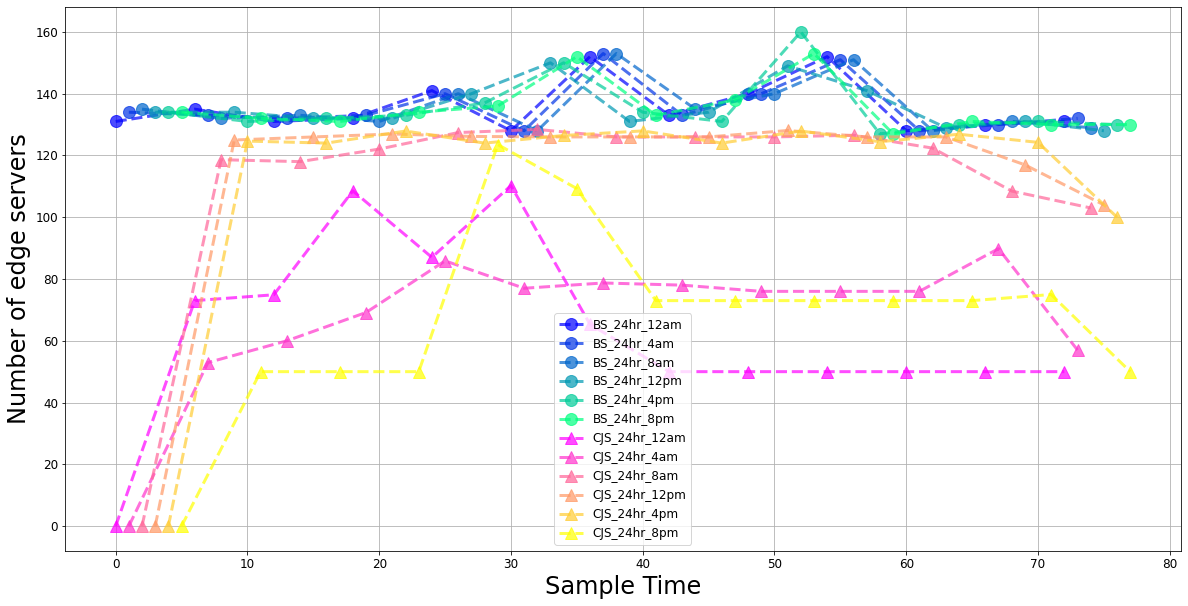

In [129]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [6*d+1 for d in range(13)]
x_axis3 = [6*d+2 for d in range(13)]
x_axis4 = [6*d+3 for d in range(13)]
x_axis5 = [6*d+4 for d in range(13)]
x_axis6 = [6*d+5 for d in range(13)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, BS_24hr_4am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_24hr_4am', alpha=0.7)
plt.plot(x_axis3, BS_24hr_8am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_24hr_8am', alpha=0.7)
plt.plot(x_axis4, BS_24hr_12pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='BS_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, BS_24hr_4pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[4]), label='BS_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, BS_24hr_8pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[5]), label='BS_24hr_8pm', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis3, estimate_N_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis4, estimate_N_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, estimate_N_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, estimate_N_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

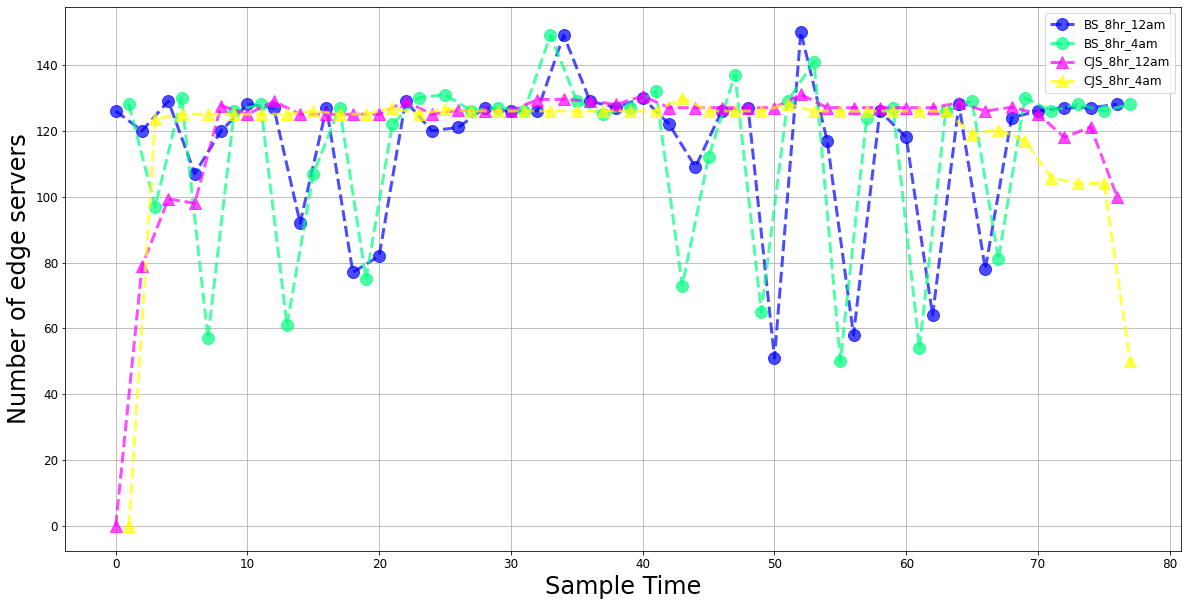

In [130]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+1 for d in range(13*3)]
color_idx = np.linspace(0, 1, 2)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

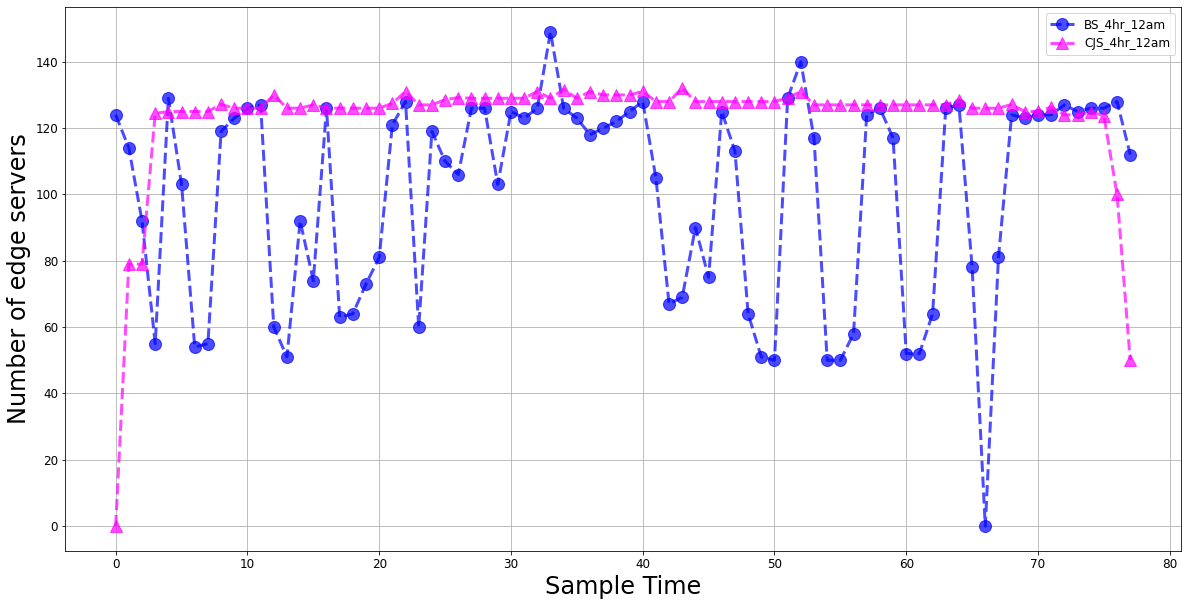

In [131]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 2)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

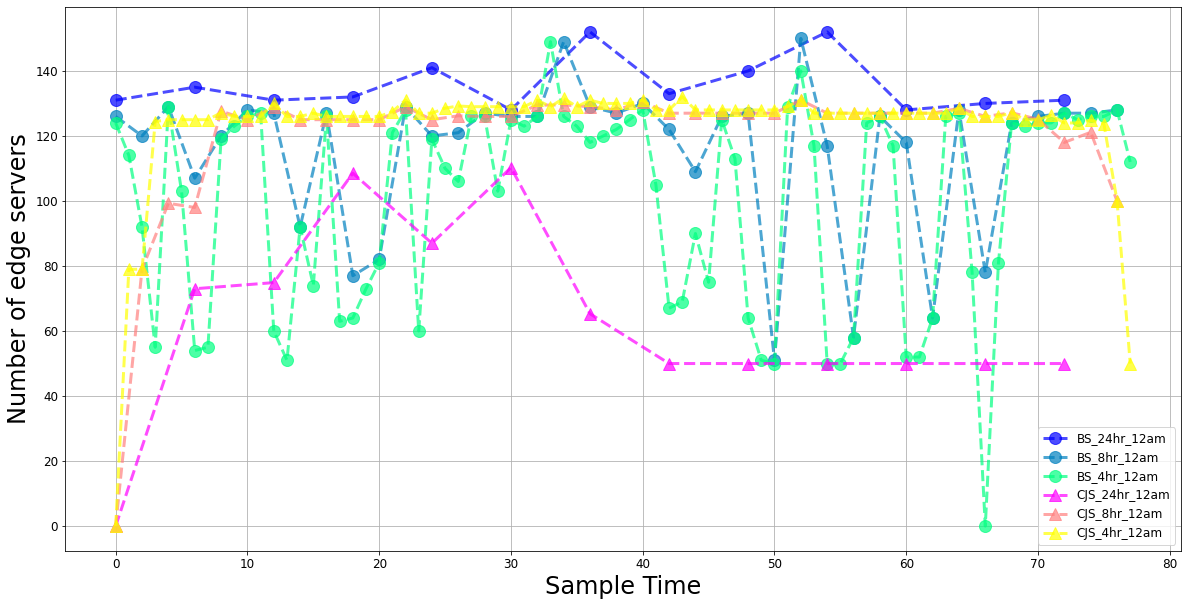

In [132]:
#CJS 12am
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_12am', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

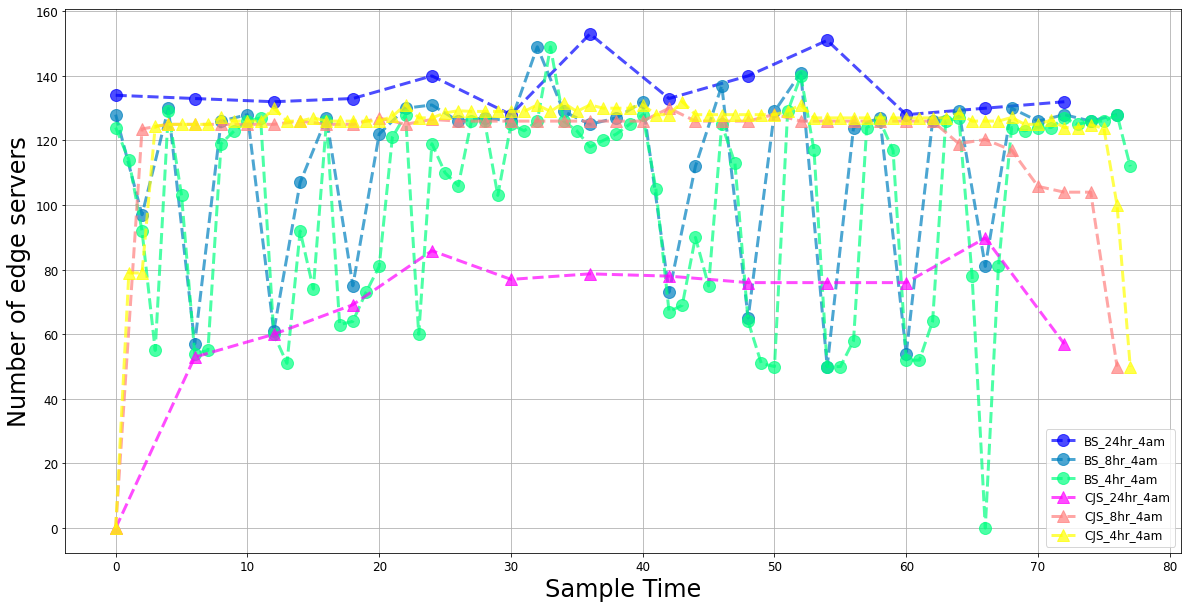

In [133]:
#CJS 4am
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_4am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_4am', alpha=0.7)
plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_4am', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_4am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

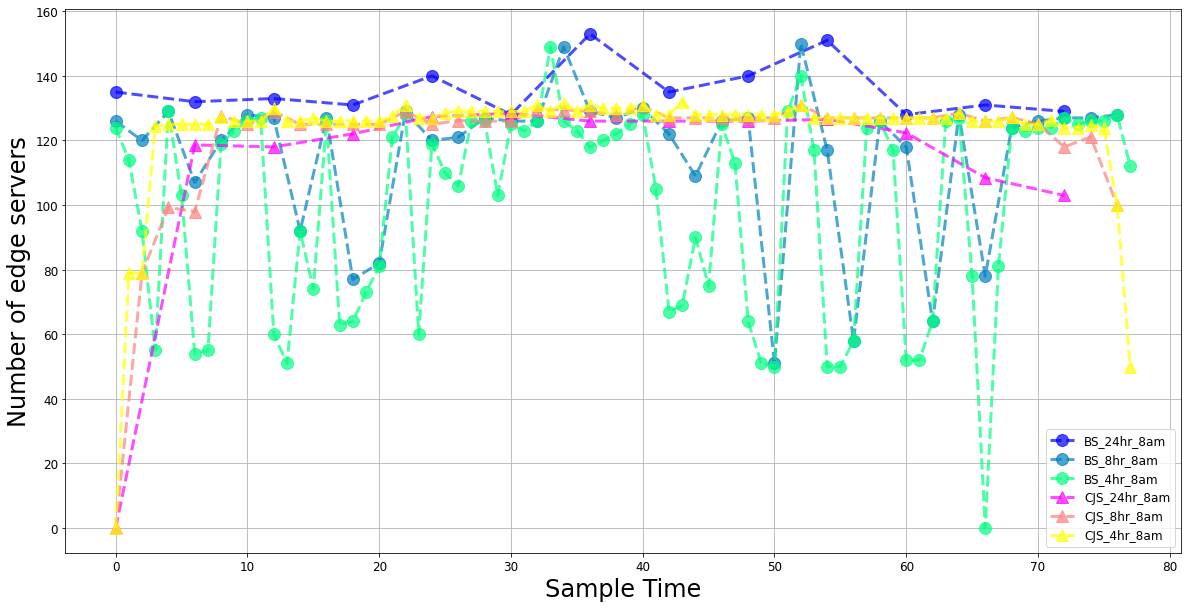

In [134]:
#CJS 8am
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_8am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_8am', alpha=0.7)
plt.plot(x_axis2, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_8am', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_8am', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_8am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_8am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

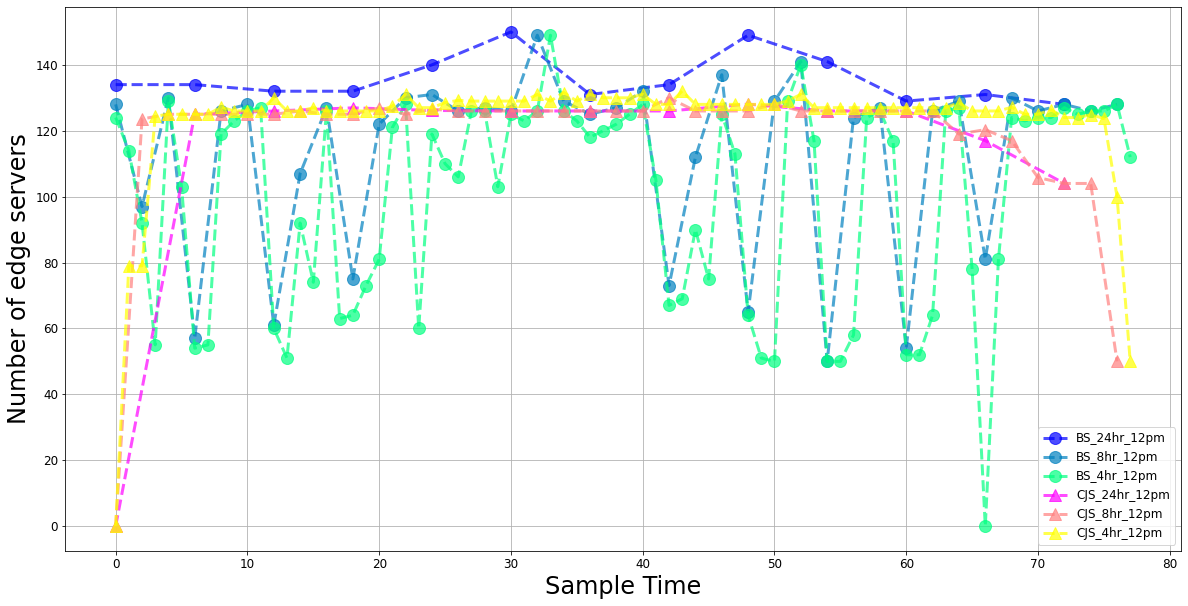

In [135]:
#CJS 12pm
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12pm', alpha=0.7)
plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_12pm', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_12pm', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12pm', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

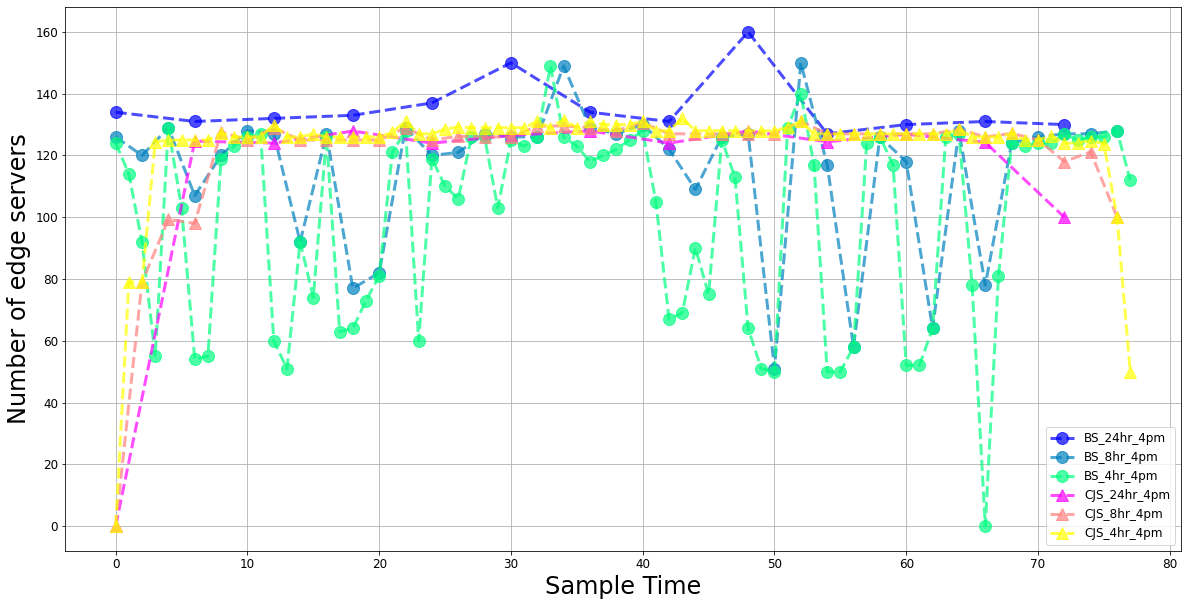

In [136]:
#CJS 4pm
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_4pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_4pm', alpha=0.7)
plt.plot(x_axis2, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4pm', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_4pm', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4pm', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_4pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

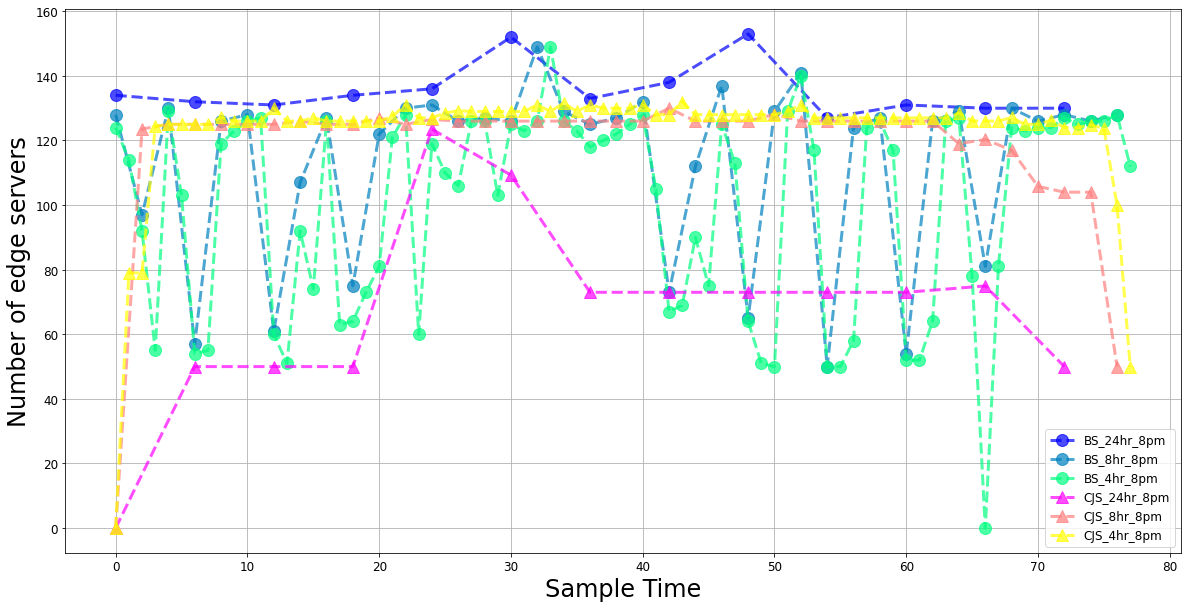

In [137]:
#CJS 8pm
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [2*d for d in range(13*3)]
x_axis3 = [d for d in range(13*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_8pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_8pm', alpha=0.7)
plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_8pm', alpha=0.7)
plt.plot(x_axis3, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_4hr_8pm', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_8pm', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_8pm', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()